In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/lukasheinrich/yadage-ipython/master/yadagealpha"
    }
});

<IPython.core.display.Javascript object>

In [3]:
import shutil
import os
import yadage_widget
import yadage.steering_object
from yadage.clihelpers import setupbackend_fromstring, prepare_workdir_from_archive

## prepare workflow

In [4]:
repolocation = 'https://raw.githubusercontent.com/lukasheinrich/weinberg-exp/master/example_yadage'
workdir = '/srv/workerdata/workdirs/ipythonwork'
try:
    shutil.rmtree(workdir)
except OSError:
    pass
finally:
    prepare_workdir_from_archive(
        workdir,
        '{}/input.zip'.format(repolocation)
    )

In [5]:
ys = yadage.steering_object.YadageSteering()
ys.prepare_workdir(workdir, accept_existing_workdir = True)

#initialize workflow with parameters
initdata ={
        'nevents':1000,
        'seeds':[1,2],
        'runcardtempl':'run_card.templ'.format(os.path.realpath(workdir)),
        'proccardtempl':'sm_proc_card.templ'.format(os.path.realpath(workdir)),
        'paramcardtempl':'param_card.templ'.format(os.path.realpath(workdir)),
        'sqrtshalf':45,
        'polbeam1':0,
        'polbeam2':0,
        'Gf': 1.766390e-05
}

ys.init_workflow(
    'rootflow.yml',
    'github:lukasheinrich/weinberg-exp:example_yadage',
    initdata, initdir = '{}/init'.format(workdir)
)


In [6]:
ui = yadage_widget.WorkflowWidget(ys.controller.adageobj)
ys.adage_argument(additional_trackers = [ui.adagetracker])
ui

## Execute Workflow

In [7]:
backend = setupbackend_fromstring('celery')
ys.run_adage(backend)

In [8]:
import json
with open(ys.controller.adageobj.view().getSteps('merge')[0].result['jsonlinesfile']) as f:
    parsed = map(json.loads,f.readlines())

In [9]:
costhetas = []
for e in parsed:
    els = [p for p in e['particles'] if p['id'] == 11]
    mus = [p for p in e['particles'] if p['id'] == 13]
    assert len(mus) == 1
    assert len(els) == 1
    mu = mus[0]
    el = els[0]
    el_px, el_py, el_pz = [el[x] for x in ['px','py','pz']]
    mu_px, mu_py, mu_pz = [mu[x] for x in ['px','py','pz']]
    costheta = mu_pz/el_pz
    costhetas.append(costheta)

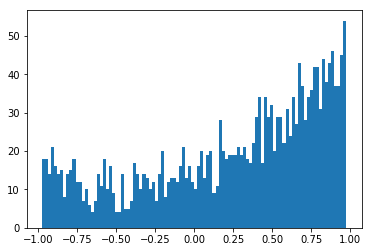

In [10]:
_,_,_ = plt.hist(costhetas, bins = 100, histtype='stepfilled')